# Image combination

Image combination serves several purposes. Combining images:

+ reduces noise in images
+ can remove transient artifacts like cosmic rays and satellite tracks
+ can remove stars in [flat images taken at twilight](FIX_LINK)

It's essential that several of each type of calibration image (bias, dark, flat)
be taken. Combining them reduces the noise in the images by roughly a factor of
$1/\sqrt{N}$, where $N$ is the number of images being combined. As shown in the
previous notebook, using a single calibration image actually *increases* the
noise in your image.

There are a few ways to combine images; if done properly, features that show up
in only one of the images (like cosmic rays) are not present in the combination.
If done incorrectly, those features show up in your combined images and then
contaminate your calibrated science images too.

### The bottom line: combine by averaging images, but clip extreme values

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R26){:target="_blank"}

The remainder of this notebook demonstrates this conclusion and explains how to
do a combination by averaging images with [ccdproc](https://ccdproc.readthedocs.io/en/latest/).

In [1]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

from astropy.visualization import hist
from astropy.stats import mad_std

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

In [3]:
# Set some default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True)

## Combination method: average or median?

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R73){:target="_blank"}

In this section we'll look at a simplified version of the challenges of
combining images to reduce noise. It's fair to think of astronomical images
(especially bias and dark images) as being a Gaussian distribution of pixel
values around the bias level, and a width related to the read noise of the
detector. To simplify what follows, we will work arrays of random numbers drawn
from a Gaussian distribution instead of with astronomical images.

In properly done flat images the noise is technically a Poisson distribution,
but with a large enough number of counts, the distribution is indistinguishable
from a Gaussian distribution whose width is related to the square root of the
number of counts. While some regions of a science image are dominated by Poisson
noise from sources in the image, most of the image will be dominated by Gaussian
read noise from the detector or Poisson noise from the sky background.

Instead of working with a combination of images, we'll create 100 Gaussian
distributions with a mean of zero, and a standard deviation of one, and combine
those two different ways: by finding the average and by finding the median. Each
distribution has size $320^2$ so that we can view it as either a distribution of
102,400 values or as an image that is $320 \times 320$.

We can think of each of these 100 distributions as representing an image, like a
bias or dark. To make the analogy to real images a little more direct, a "bias"
of 1000 is added to each distribution.

In [4]:
n_distributions = 100
bias_level = 1000
n_side = 320
bits = np.random.randn(n_distributions, n_side**2) + bias_level
average = np.average(bits, axis=0)
median = np.median(bits, axis=0)

Now that we've created the distributions and combined them in two different
ways, let's take a look at them. The [`hist` function from astropy.visualization](https://astropy.readthedocs.io/en/stable/visualization/histogram.html) is used
below because it can figure out what bin size to use for your data.

<!-- *Note: but beware https://github.com/astropy/astropy/issues/7758* -->

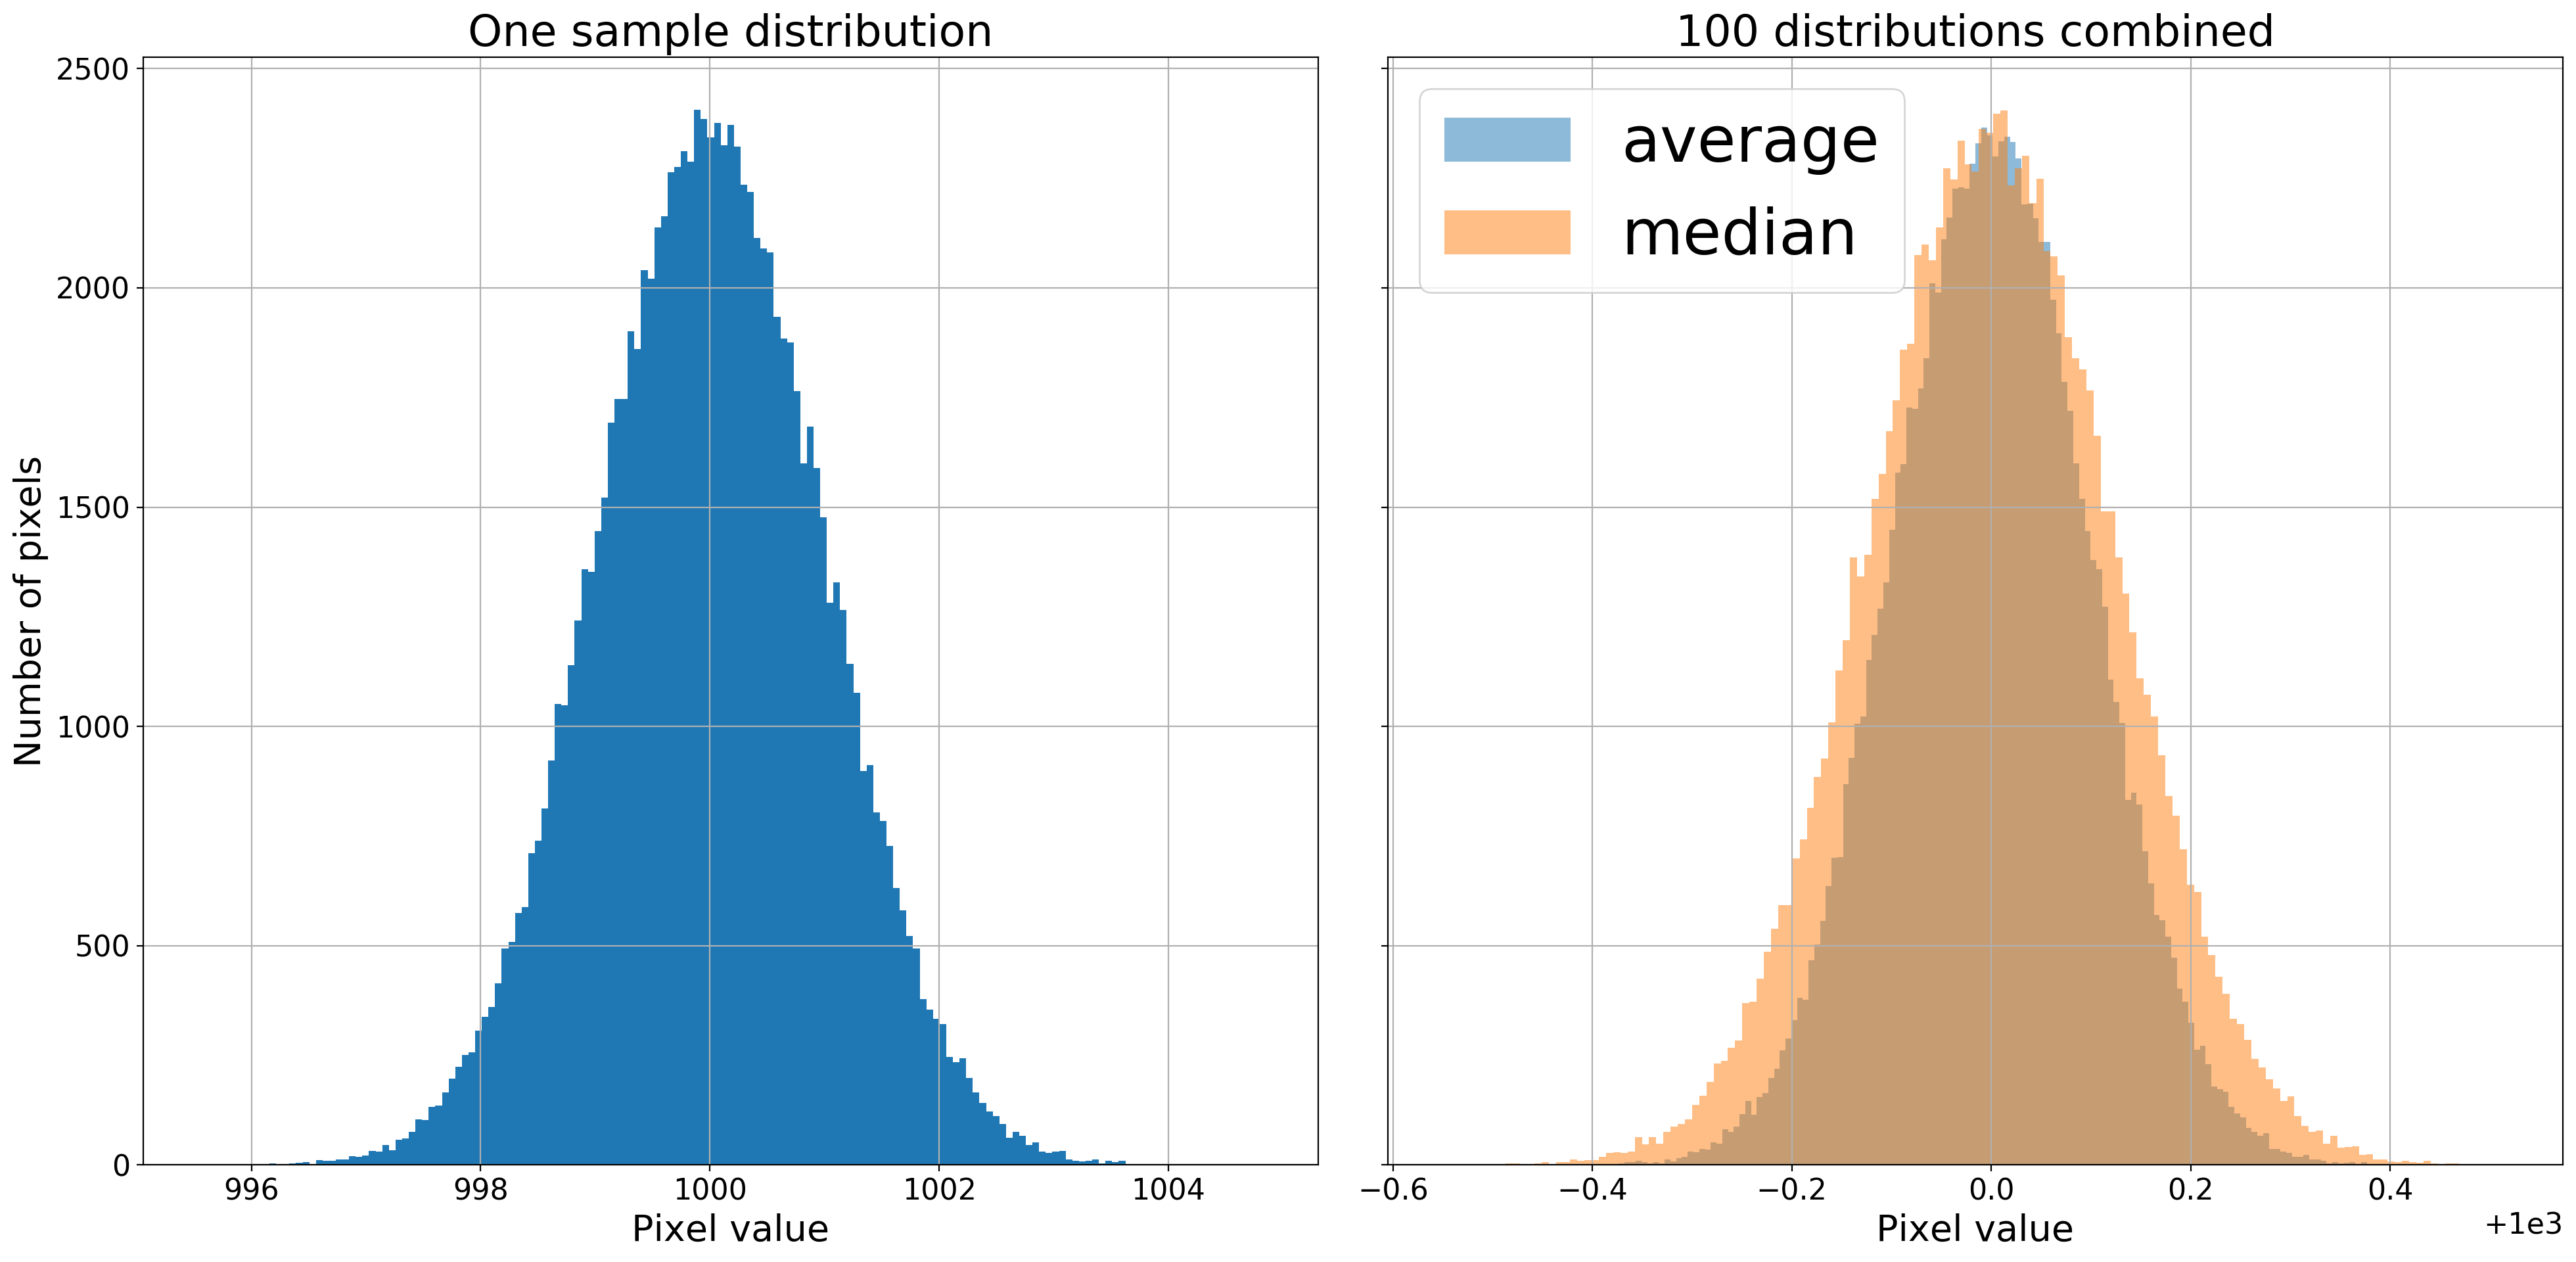

In [5]:
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(20, 10))

hist(bits[0, :], bins='freedman', ax=ax[0]);
ax[0].set_title('One sample distribution')
ax[0].set_xlabel('Pixel value')
ax[0].set_ylabel('Number of pixels')

hist(average, bins='freedman', label='average', alpha=0.5, ax=ax[1]);
hist(median, bins='freedman', label='median', alpha=0.5, ax=ax[1]);
ax[1].set_title('{} distributions combined'.format(n_distributions))
ax[1].set_xlabel('Pixel value')
ax[1].legend()

Combining by averaging gives a narrower (i.e. less noisy) distribution than
combining by median, though both substantially reduced the width of the
distribution. The conclusion so far is that combining by averaging is mildly
preferable to combining by median. Computationally, the mean is also faster to
compute than the median.

### Image view of these distributions

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R160){:target="_blank"}

As suggested above, we could view each of these distributions as an image
instead of a histogram. One take away from the diagram below is that in this
case, the difference between mean and median is not apparent.

In all cases, the extreme values of the image display are set to bracket the
width of the initial distribution.

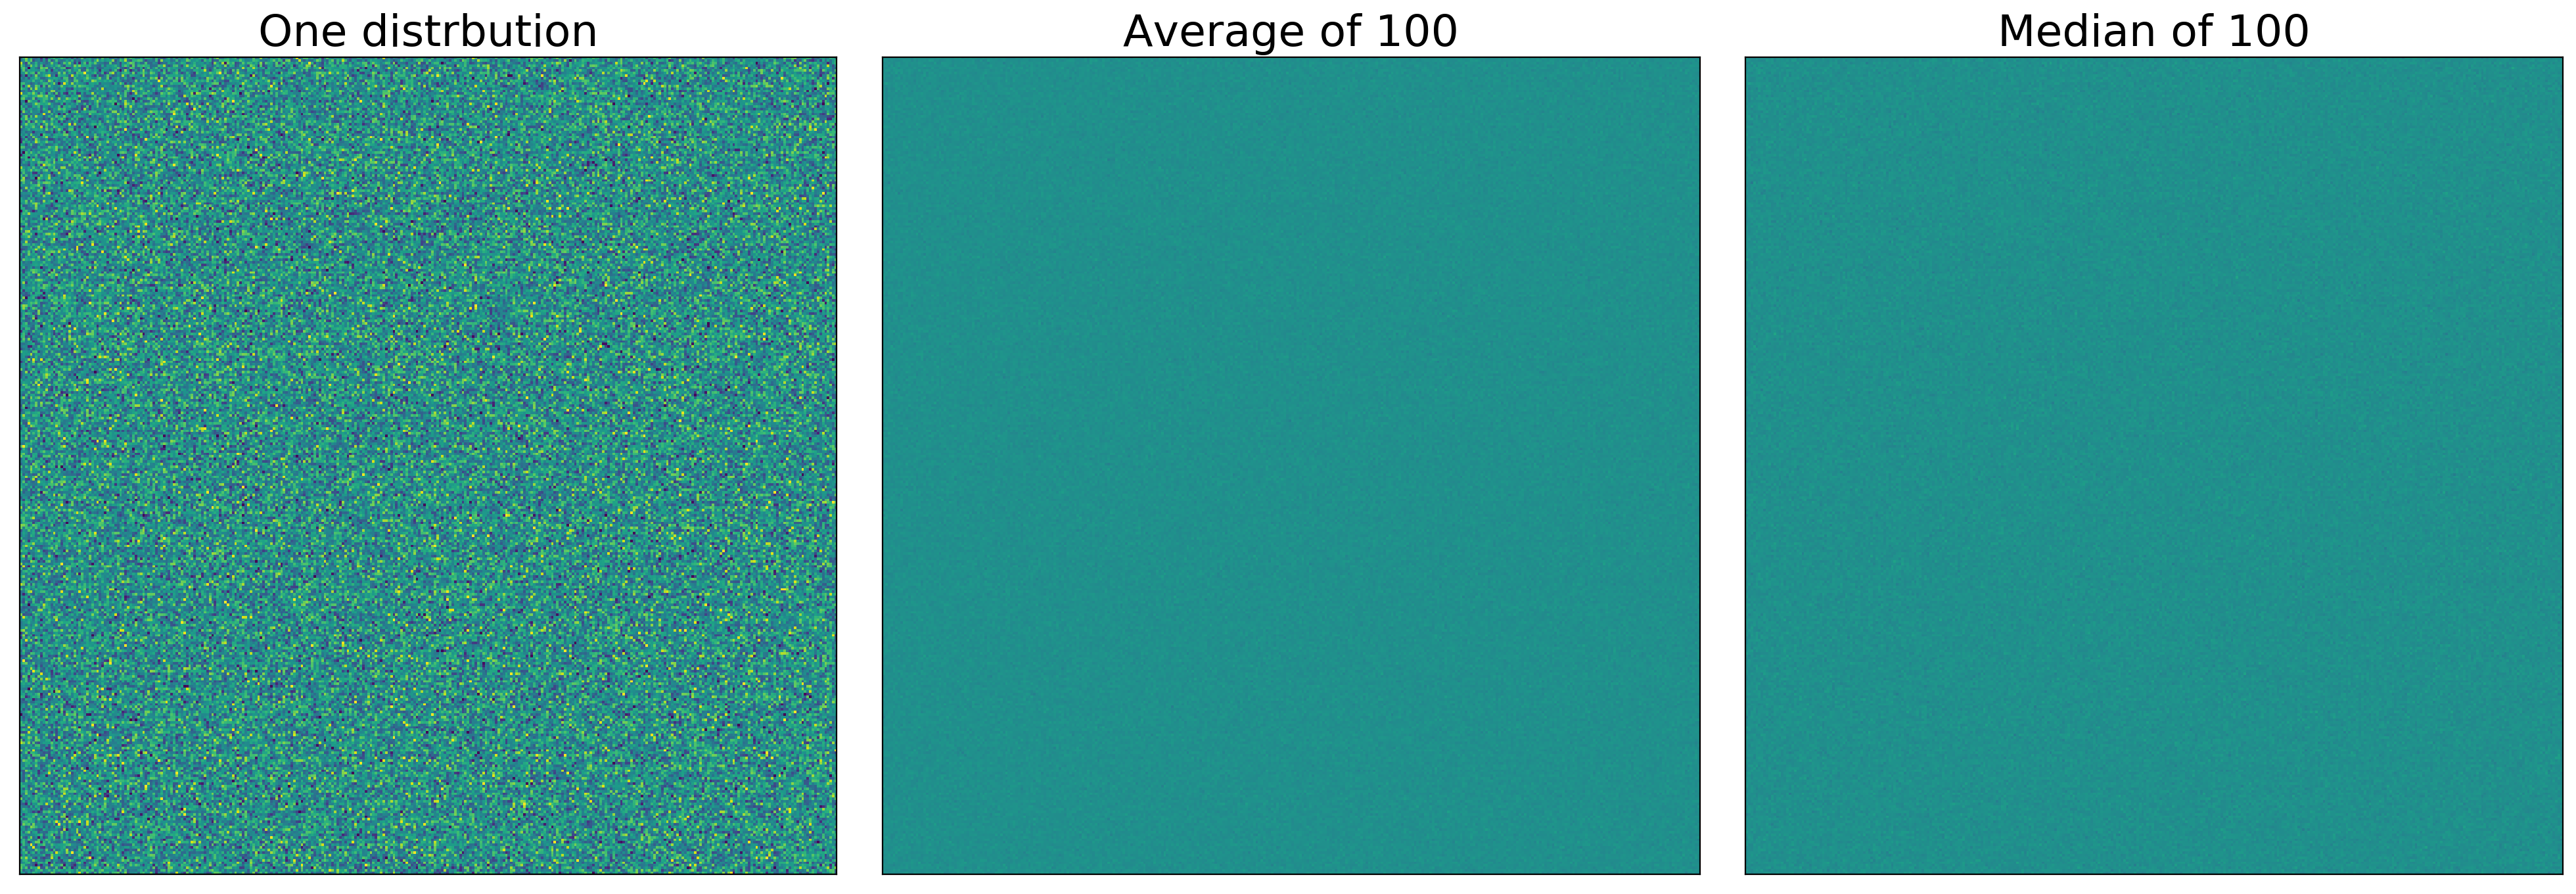

In [6]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(20, 10))
data_source = [bits[0, :], average, median]
titles = ['One distrbution', 'Average of {n}'.format(n=n_distributions), 'Median of {n}'.format(n=n_distributions)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)

## The effect of outliers

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R192){:target="_blank"}

Suppose that, in just one of the 100 distributions we're combining, there are a
small number of extreme values. In astronomical images these extremes happen
very frequently because of cosmic ray hits on the detector that cause, in one
small patch of a calibration image, much higher counts. Another case occurs when
combining twilight flats, which often contain faint images of stars.

In the example below, we set just 50 points out of the 102,400 in the first
distribution to a somewhat higher value than the rest.

In [7]:
bits[0, 10000:10050] = 2 * bias_level

Remember, we can think of the values in this distribution as an image, a view
that will be particularly convenient in this case.

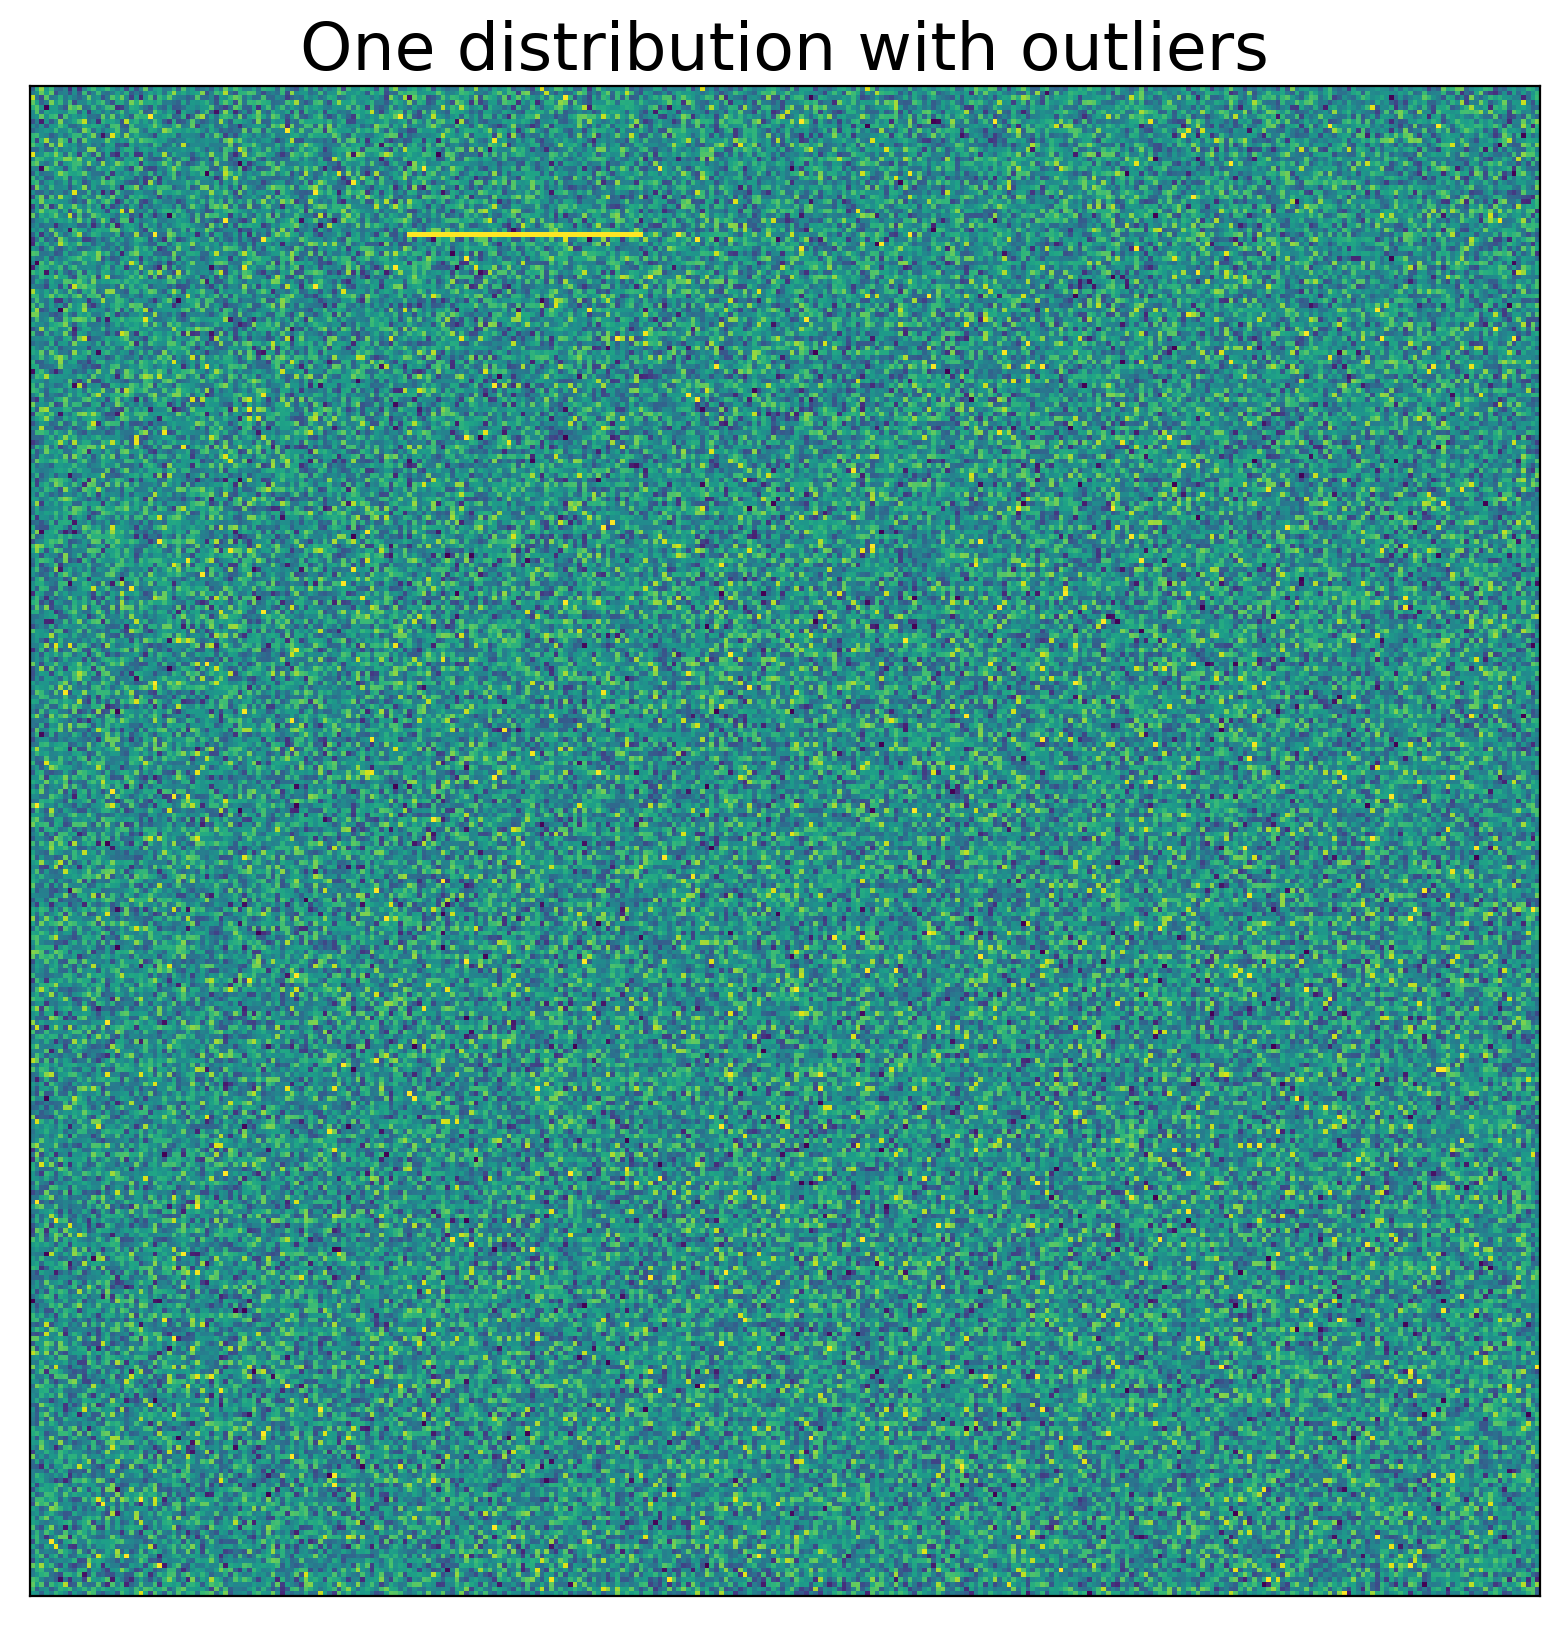

In [8]:
plt.imshow(bits[0, :].reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
plt.xticks([])
plt.yticks([])
plt.title('One distribution with outliers')
plt.grid(False)

Now that we know what the outliers in this (and *only* this) distribution look
like, we'll combine all of the distributions as we did above.

In [9]:
average = np.average(bits, axis=0)
median = np.median(bits, axis=0)

Even though only one out of the 100 "images" we're combining has these high
pixel values, the distribution of pixels for the average is clearly affected
(well, maybe not clearly, since seeing it requires a logarithmic $y$-axis). The
distribution for the median looks much the same as above. Since median simply
looks for the middle value, an extreme value doesn't affect the result too much.

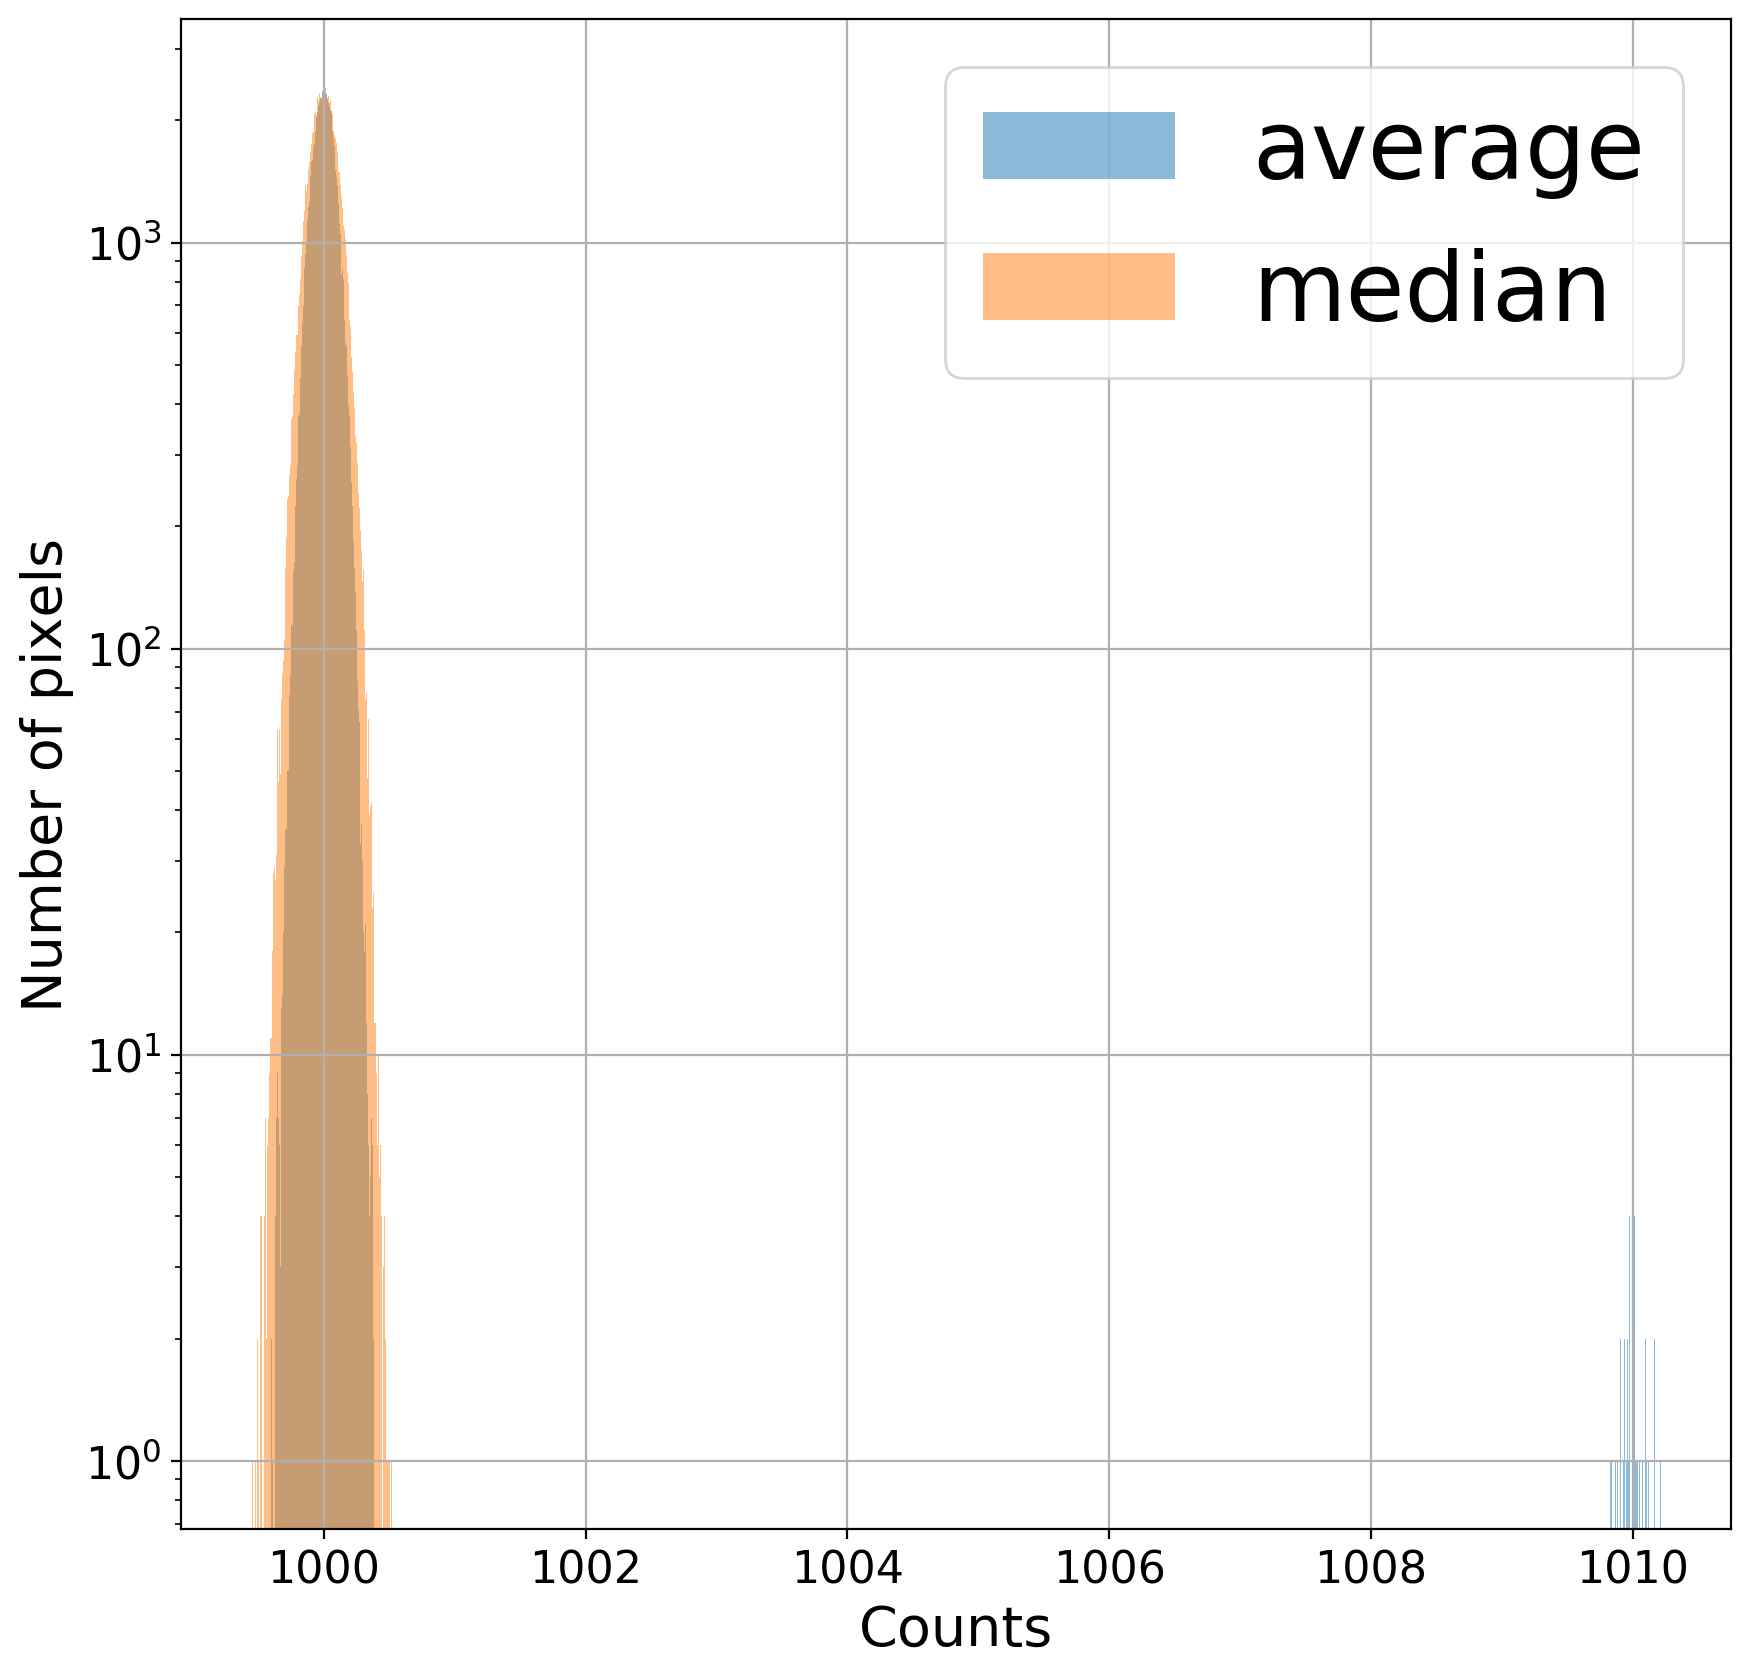

In [10]:
plt.figure(figsize=(10, 10))
hist(average, bins='freedman', alpha=0.5, label='average');
hist(median, bins='freedman', alpha=0.5, label='median');
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Number of pixels')
plt.semilogy();

### Combining using the average has a noticeable effect on the result; median

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R282){:target="_blank"}
removes the artifact

The effect of the outlier is *much* clearer if the distributions are displayed
as images. If the distributions we're combining were calibration images then the
outliers that appear in one image (e.g. a cosmic ray) would affect the combined
image we hoped to use for calibration.

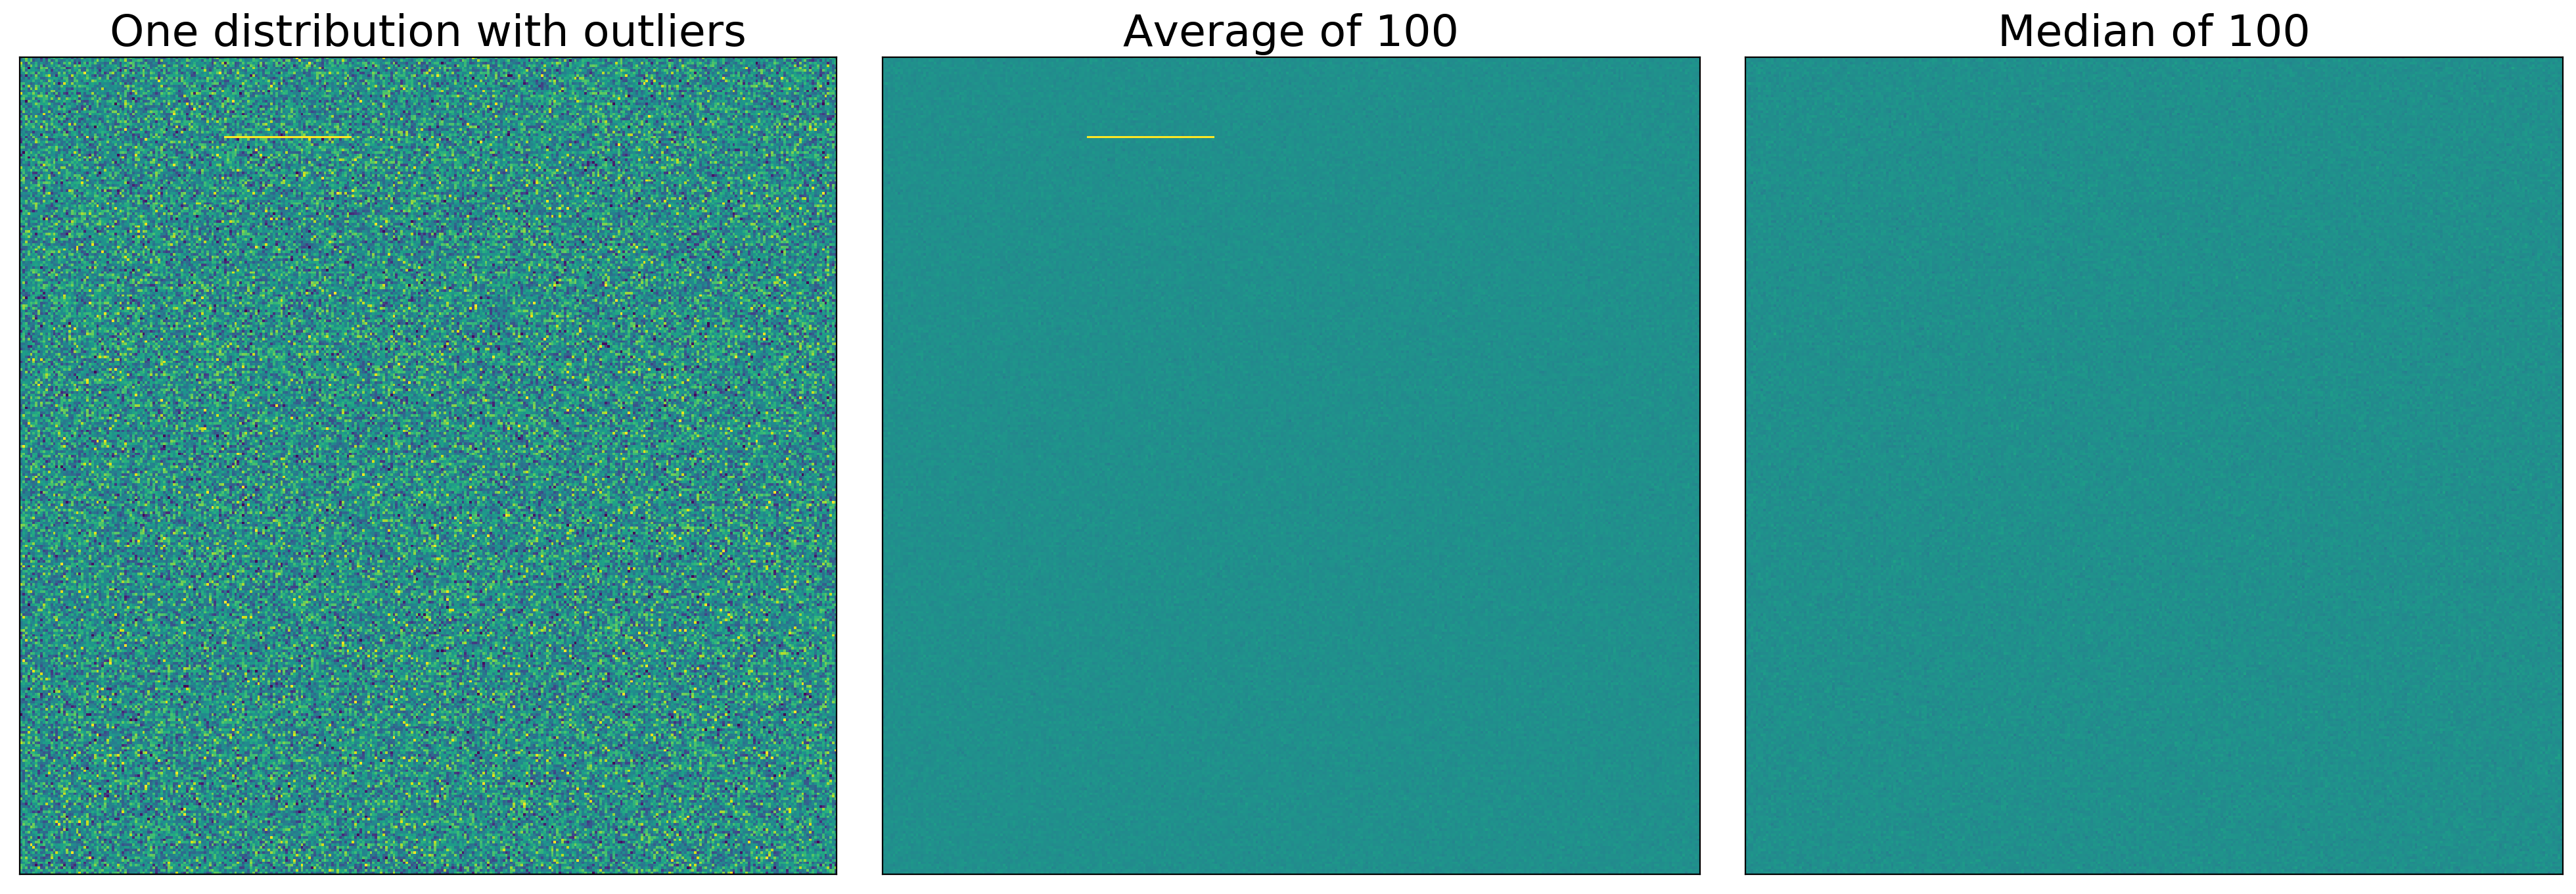

In [11]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(20, 10))
data_source = [bits[0, :], average, median]
titles = ['One distribution with outliers', 'Average of {n}'.format(n=n_distributions), 'Median of {n}'.format(n=n_distributions)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)


On one hand, the noise properties are better when you combine by taking the
average. On the other hand, the median eliminates features that appear in only
one image.

Astronomical images will almost always have those transient features. Even at an
observatory near sea level in an exposure that is very short, cosmic ray hits
are common.

## The solution: average combine, but clip the extreme values

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R326){:target="_blank"}

The answer here is to first clip extreme values from the distributions and then
combine using the average. That rejects outlying values like the median but with
the modestly better statistical properties of the average. A method called
"sigma clipping" is used to remove the extreme values.

**Please do not use the code below for reducing your data...**

...in the next set of notebooks we'll walk through the package
[ccdproc](https://ccdproc.readthedocs.io), which automates much of what you see below.
The section below demonstrates and explains some of what's happening behind the
scenes in [ccdproc](https://ccdproc.readthedocs.io).

### Sigma clipping

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R350){:target="_blank"}

Sigma clipping means calculating how "far" each pixel to be combined is from the
"typical" value and excluding values from the combination if they are "too far"
from the pixel value.

To be clear, when evaluating which values to reject we're doing it for each of
the 102,400 points in the distribution (or, if you prefer, each of the
320$\times$320 pixels in the image) we're going to combine. In other words, for
each point (or pixel), we'll compute a "typical" value for the 100 distributions
(images) we're combining and exclude any from the average that are "too far"
from the "typical value."

What should be used as the "typical" value, how do we measure how "far" away a
value is, and how far is "too far"?

The last question is easiest to answer: it depends a bit on the noise level in
your camera but something like 5 farther from the "typical" value than most of
the pixels are.

Using the average as the typical value and the standard deviation as a measure
of how far a particular value is from the typical value is often not the best
choice. The problem with this is that outlying values in a single distribution
(or image) strongly bias the average and exaggerate the standard deviation. In
this example, where we're combining 100 distributions (images), using the
average and standard deviation might work since there are so many distributions.
A more typical number of bias or dark images that one might combine is 10 or 20.
In that case, an extreme value in one image strongly affects the mean and
standard deviation.

As an example, consider combining 10, 20, or 100 of our distributions, as shown
in the cell below. Only in the case of 100 distributions would our extreme value
of 2000 be excluded if we excluded values more than 5 times the standard
deviation from the average.

In [12]:
print('Number combined\t Average\t Standard dev σ \t 10σ ')

for n_to_combine in [10, 20, n_distributions]:
    avg = np.mean(bits[:n_to_combine, 10000])
    std = np.std(bits[:n_to_combine, 10000])
    print('{n:10d}\t{avg:10.2f}\t{std:10.2f}\t{ten_sig:10.2f}'.format(n=n_to_combine, 
                                         avg=avg, 
                                         std=std, ten_sig=10 * std))

Number combined	 Average	 Standard dev σ 	 10σ 
        10	   1099.87	    300.04	   3000.43
        20	   1049.93	    217.96	   2179.62
       100	   1009.96	     99.51	    995.07


A better choice is to use the median as the typical value and the *median
absolute deviation* in place of the standard deviation as the measure of how far
a value is from the typical value. The [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation), or MAD,
of a set of points $x$ is defined by:
$$
MAD = \frac{1}{N}\sum_{i=0}^N |x_i - \text{median}(x)|.
$$
This is a measure of the typical absolute distance from the median of the set of
values. The MAD is not directly equivalent to the standard deviation. The
relationship between the two depends on the distribution of values, but for a
Gaussian distribution multiplying the MAD by 1.4826 does the trick. The
[astropy function `mad_std`](http://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html) will calculate the MAD and multiply by the
appropriate factor for you.


Repeating the calculation above but with median as the central value and the MAD
in place of the standard deviation demonstrates that even for 10 distributions
the extreme value will be excluded.

In [13]:
print('{:^20}{:^20}{:^20}{:^20}'.format('Number combined', 'Median', 'MAD σ', '10σ'))

for n_to_combine in [10, 20, n_distributions]:
    avg = np.median(bits[:n_to_combine, 10000])
    std = mad_std(bits[:n_to_combine, 10000])
    print('{n:^20d}{avg:^20.2f}{std:^20.2f}{ten_sig:^20.2f}'.format(n=n_to_combine, 
                                         avg=avg, 
                                         std=std, ten_sig=10 * std))

  Number combined          Median              MAD σ                10σ         
         10                999.98               0.77                7.69        
         20               1000.11               0.95                9.52        
        100                999.98               0.96                9.60        


The downside to using the median and median absolute deviation? They can be slow
to compute for large images or large stacks of images.

The cells below perform the actual clipping; you should generally use the
astropy function [`sigma_clip`](https://astropy.readthedocs.io/en/stable/stats/robust.html) to do this, but here we'll do
it manually to illustrate the process.

We begin by calculating the MAD standard deviation estimator for our data.

In [14]:
mad_sigma = mad_std(bits, axis=0)

The expression below is true for all of the points farther than $10
\sigma_{MAD}$ from the median of the distributions and false everywhere else.
This array will be used to exclude the extreme points.

In [15]:
exclude = (bits - median) / mad_sigma > 10

Next, we calculate the average, excluding the points identified as "too far"
from from the median. There are two approaches we can take here. One is to use
numpy masked arrays; the other is to temporarily set the excluded values to the
special value `np.nan` and use a numpy function that excludes `nan` from the
calculation. The latter approach is often faster than the former.

The best approach is really to use a higher-level function from astropy for
ccdproc. Those will take care of the details of implementing the clipping for
you.

In [16]:
original_values = bits[exclude]
bits[exclude] = np.nan

clip_combine = np.nanmean(bits, axis=0)
bits[exclude] = original_values

## Summary

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/126/files#diff-976ff4558111a0c8cd9acea1b437a089R520){:target="_blank"}

Combine images by (1) excluding extreme values using sigma clipping, with the
median as the typical value and the MAD estimator of the standard deviation, and
then (2) averaging the remaining pixels across all of the images.

Note that in the distribution below the clipped average is a narrower
distribution (less noise) than the median but that it still excludes the extreme
value that appeared in one image.

Text(0, 0.5, 'Number of pixels')

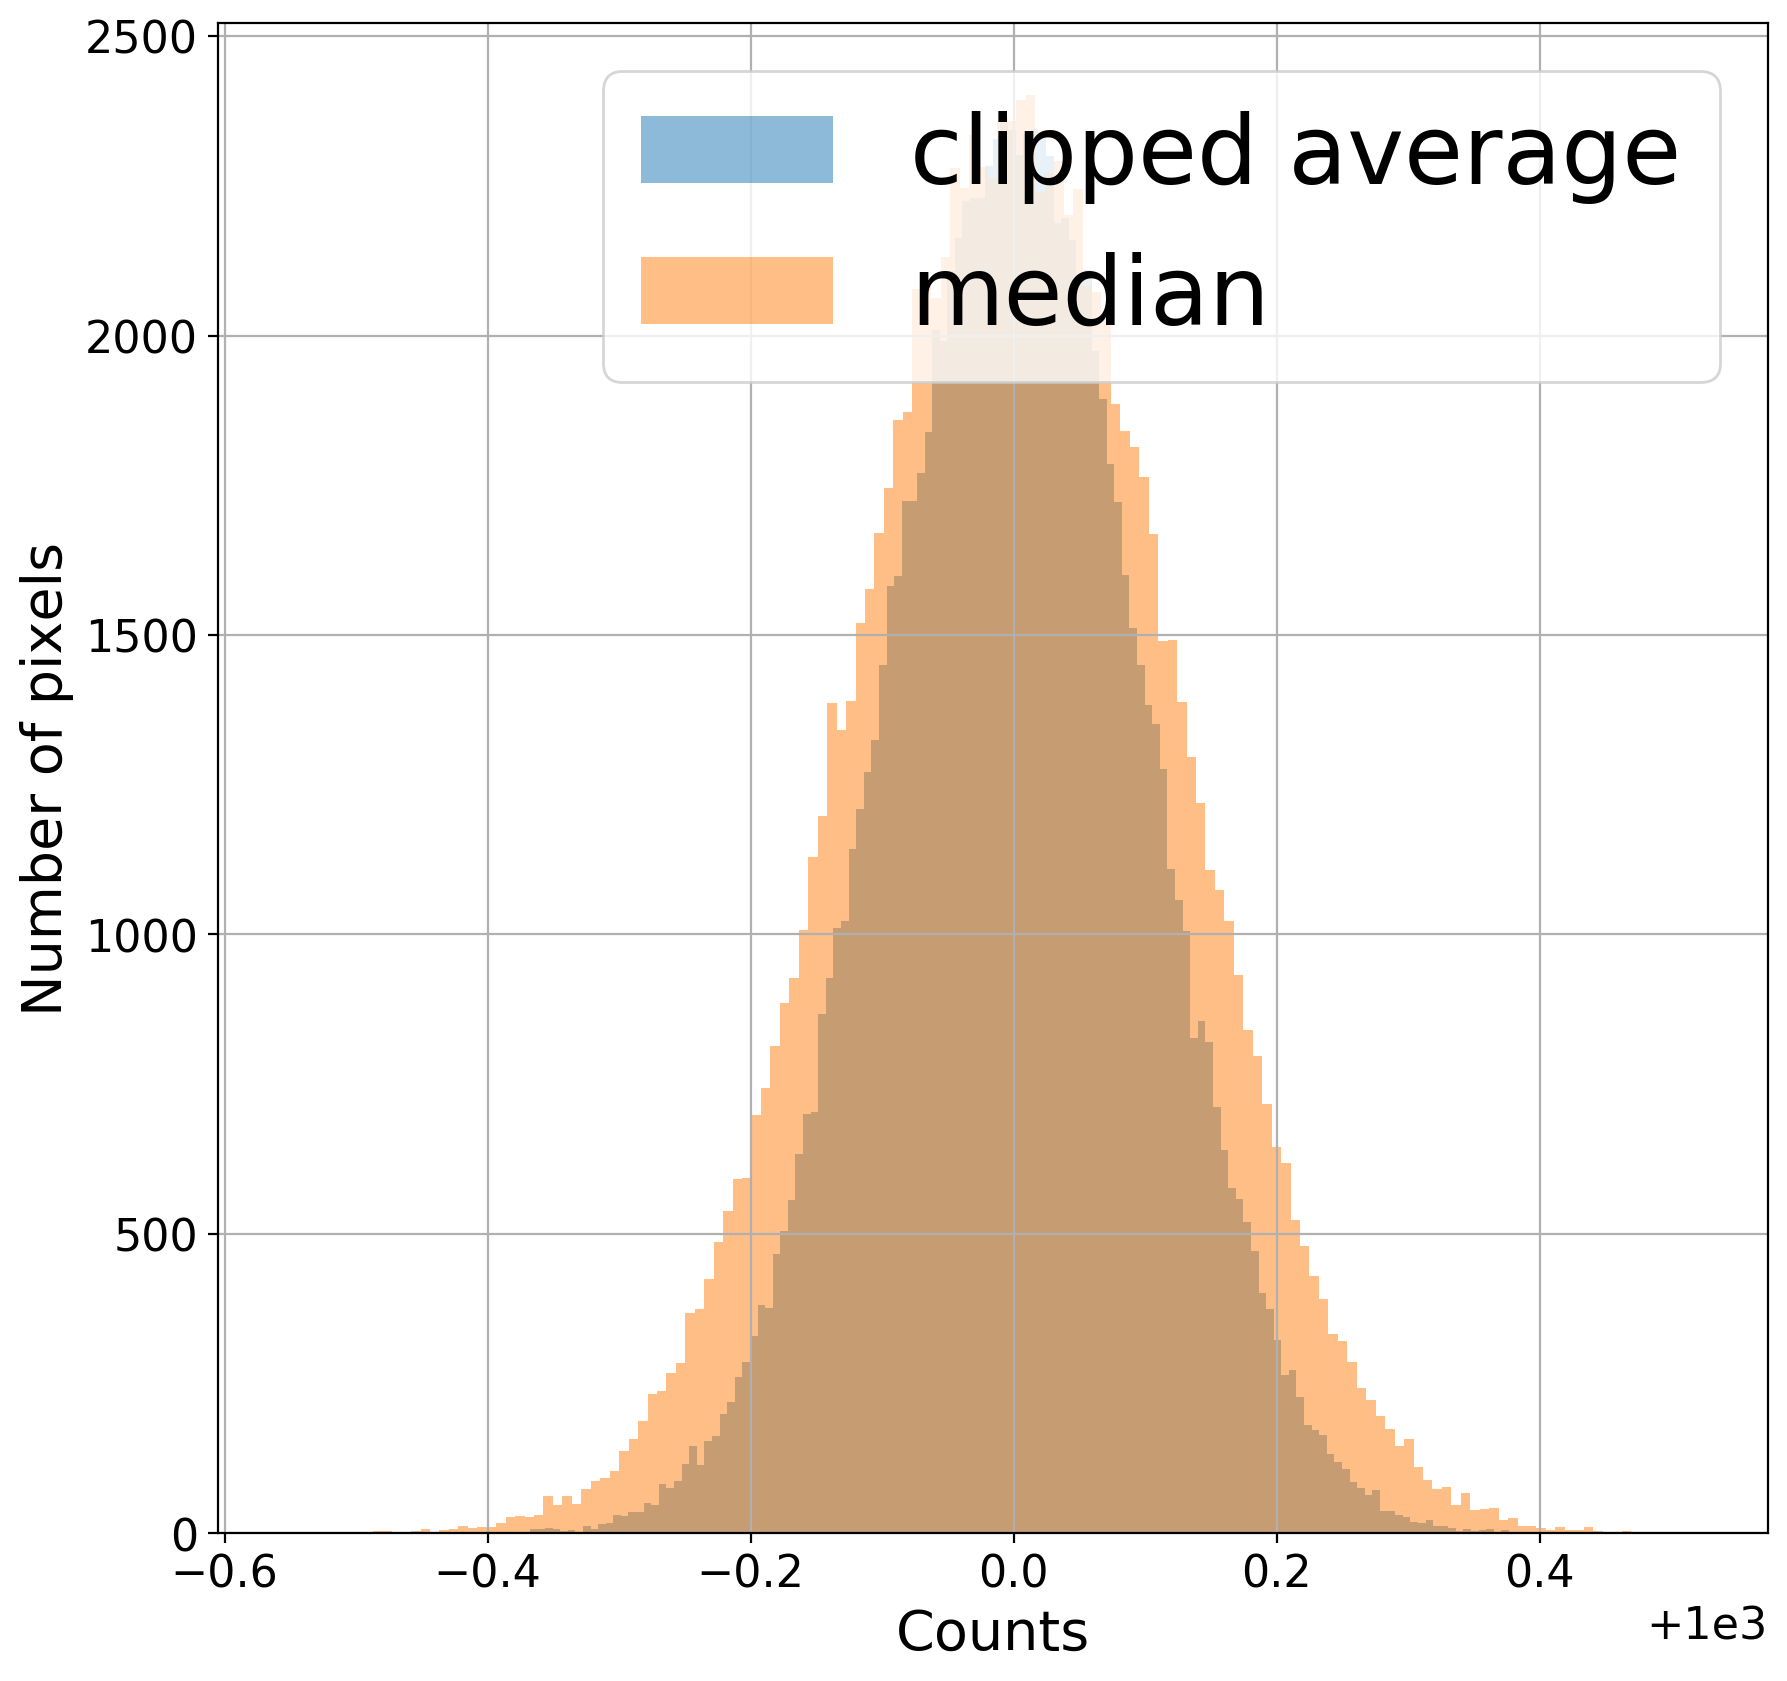

In [17]:
plt.figure(figsize=(10, 10))
hist(clip_combine, bins='freedman', alpha=0.5, label='clipped average')
hist(median, bins='freedman', alpha=0.5, label='median');
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Number of pixels')